In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sys
sys.path.append("../src")
import utils.data_preparation as dp
import utils.metrics as metrics
from models import siamese

In [3]:
# read data
data = np.load("../Data/RayTracingData/Remcom_4x4_IR_100taps.npy")

In [4]:
#one sample example
imag_mean = np.mean(np.imag(data))
imag_std = np.std(np.imag(data))
real_mean = np.mean(np.real(data))
real_std = np.std(np.real(data))
one_sample = data[0:2,:,25:75]
one_sample_real = (np.real(one_sample) - real_mean)/real_std
one_sample_imag = (np.imag(one_sample) - imag_mean)/imag_std

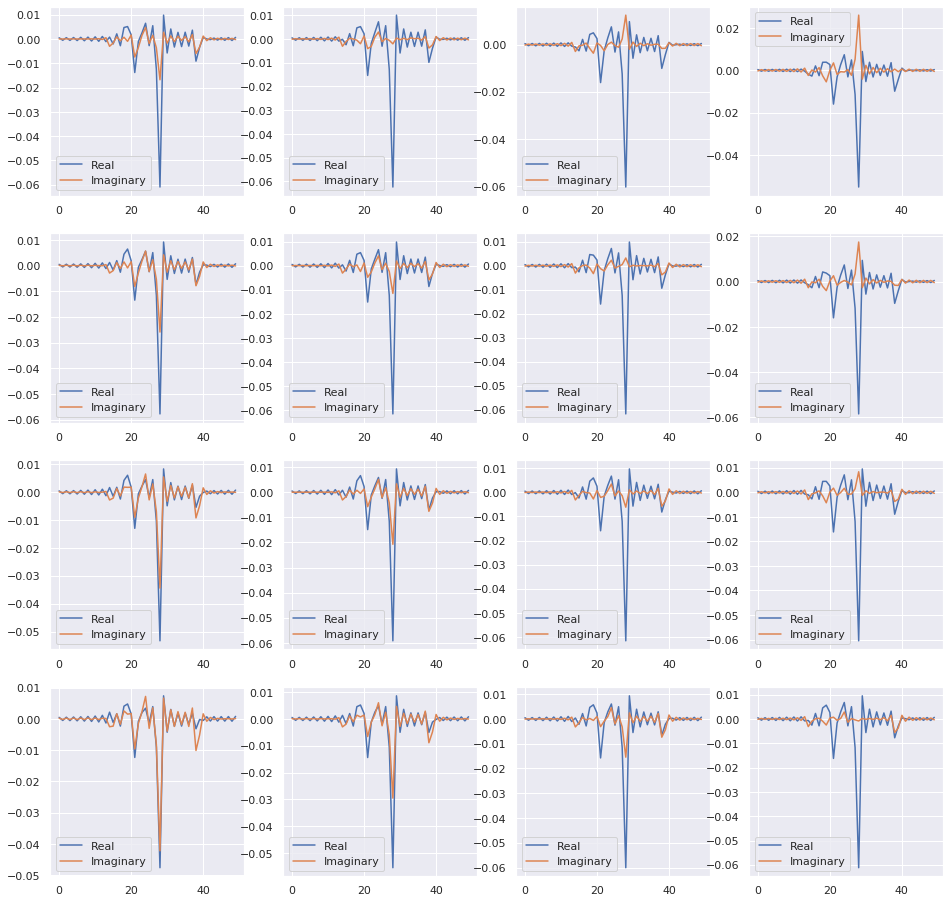

In [5]:
plt.figure(figsize=(16,16))
for i  in range(1, 17):
    plt.subplot(4,4,i)
    plt.plot(one_sample_real[0, i-1, :], label='Real')
    plt.plot(one_sample_imag[0, i-1, :], label='Imaginary')
    plt.legend()

In [6]:
one_sample_full = np.concatenate([one_sample_real, one_sample_imag], axis=0)

In [7]:
one_sample_full.shape

(4, 16, 50)

We observe that a lot of information is contained on the imaginary part of the impulse. So the 16 antennas, we are gong to have 32 'Channels' for our dataset. 
So we will have a training batch of shape [batch_size, 32 , 100].

# Siamese Neural Network

In [8]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

## Setting up the Custom Dataset

In [9]:
# undersampling
idces = np.random.randint(0, data.shape[0], int(0.1*data.shape[0]))
data_undersampled = data[idces]

In [10]:
data_undersampled.shape

(2392, 16, 100)

In [11]:
data_undersampled.shape
# train test split
train, test= train_test_split(data_undersampled)

In [12]:
train_dataset = dp.SiameseDataset(train)
scaler = train_dataset.scaler_real, train_dataset.scaler_imag
test_dataset = dp.SiameseDataset(test, scaler)

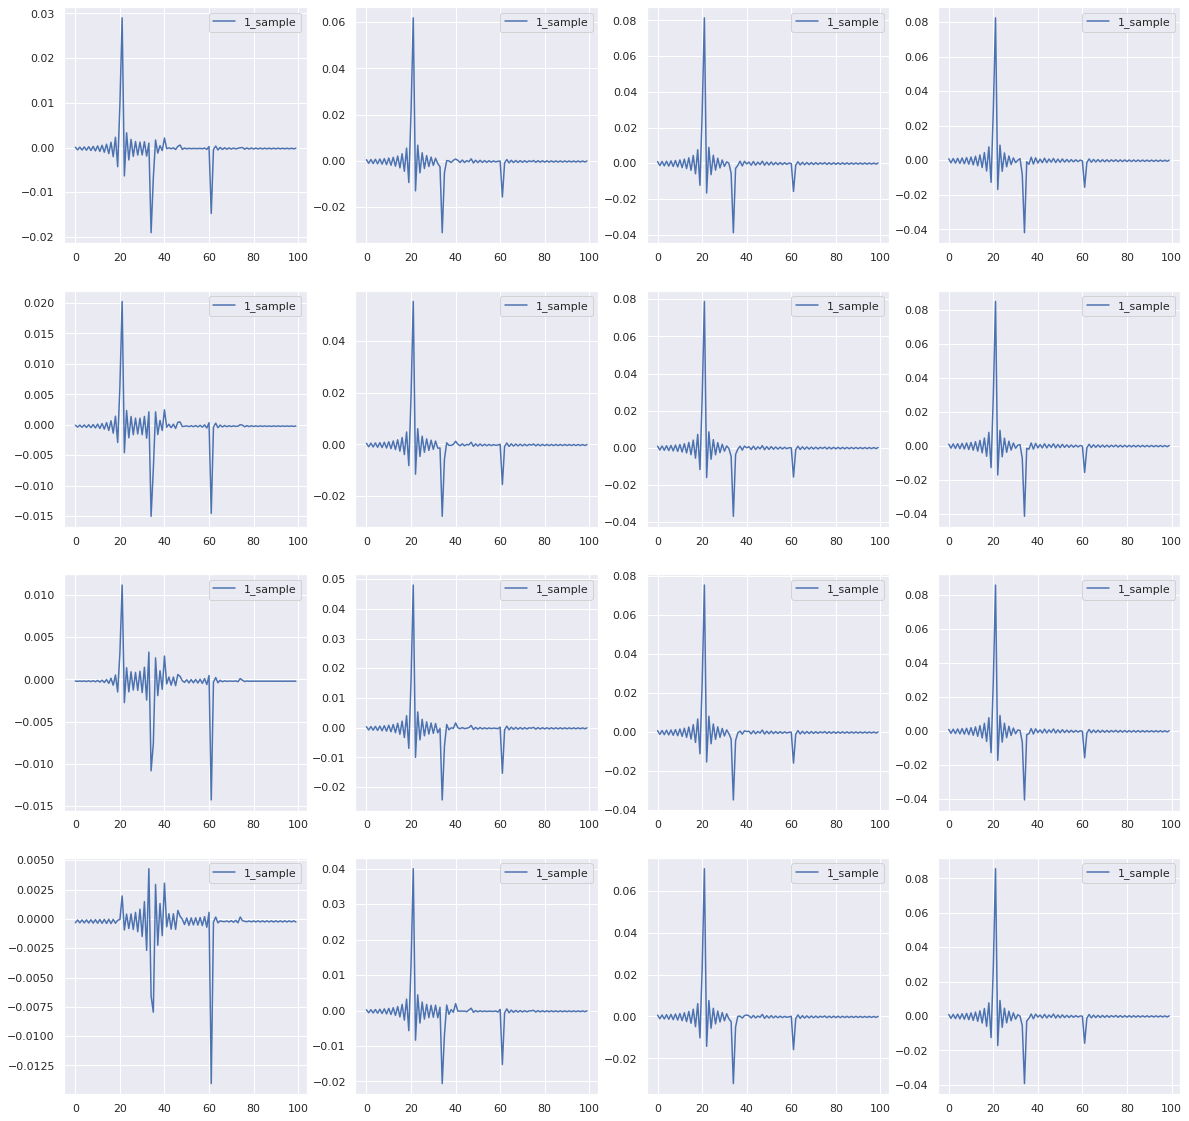

In [13]:
plt.figure(figsize=(20,20))
for i  in range(1, 17):
    plt.subplot(4,4,i)
    plt.plot(train_dataset[0][0][i-1, :], label='1_sample')
    #plt.plot(train_dataset[0][1][i-1, :], label='2_sample')
    plt.legend()

In [14]:
train_dataset.nb_channels()

32

In [15]:
class SimpleNN(nn.Module):
    def __init__(self, dropout):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=train_dataset.nb_channels(),
                          out_channels=128,
                          kernel_size=16)
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(in_channels=128, 
                          out_channels=64,
                          kernel_size=8)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(in_channels=64,
                          out_channels=16,
                          kernel_size=4)
        self.bn3 = nn.BatchNorm1d(16)
        
        f = siamese.conv1d_output_size
        self.features = f(f(f(train_dataset.nb_samples(),kernel_size=16),
                                                       kernel_size=8), 
                                                         kernel_size=4)

        
        
        self.lin1 = nn.Linear(in_features= 16 * self.features, out_features=128)
        self.lin2 = nn.Linear(in_features=128, out_features=32)
        self.lin3 = nn.Linear(in_features=32, out_features=8)
        self.lin4 = nn.Linear(in_features=8, out_features=2)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.lin1(x)))
        x = self.dropout(F.relu(self.lin2(x)))
        x = self.dropout(F.relu(self.lin3(x)))
        
        out = self.lin4(x)
        
        return out
        
    

In [16]:
dropout = 0.3
model = SimpleNN(dropout)

In [17]:
def loss_function(x1, x2, y1, y2):
    return torch.sum((torch.dist(x1,x2) - torch.dist(y1, y2))**2/(torch.dist(x1,x2) + 1e-5))

In [43]:
x1, x2 = train_dataset[0:100][0], train_dataset[0:100][1]
y1, y2 = model(x1), model(x2)

## Evaluate results

### Unsupervised Evaluation

#### Trustworthiness

In [44]:
y1 = y1.unsqueeze(2)

In [45]:
y1.shape

torch.Size([100, 2, 1])

In [46]:
tw = np.mean(metrics.trustworthiness(x1, y1))
ct = np.mean(metrics.continuity(x1,y1))

In [48]:
tw ,ct

(1.000217391304348, 0.9964986956521739)

In [49]:
y1 = y1.detach()

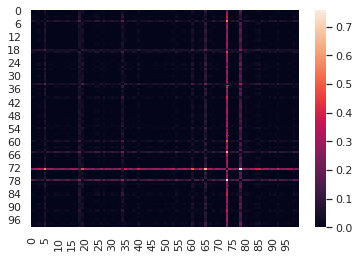

In [24]:
sns.heatmap(metrics.distance_matrix(y1))

In [25]:
metrics.rank_matrix(metrics.distance_matrix(x1))

tensor([[ 0, 25,  1,  ..., 35, 80, 39],
        [55,  0, 44,  ..., 34, 80, 38],
        [54, 16,  0,  ..., 34, 80, 39],
        ...,
        [55, 13, 44,  ...,  0, 80, 38],
        [ 4, 35,  6,  ..., 16,  0, 44],
        [55, 12, 44,  ..., 35, 80,  0]])

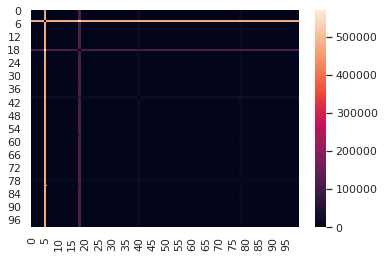

In [26]:
sns.heatmap(metrics.distance_matrix(x1))

In [54]:
ct = metrics.continuity(x1, y1)

In [55]:
tw = metrics.trustworthiness(x1,y1)

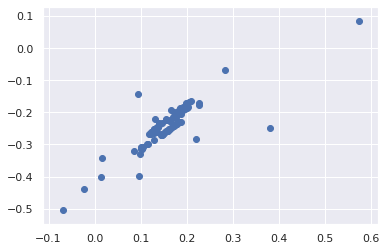

In [27]:
plt.scatter(y1[:,0], y1[:,1])

In [28]:
rx_positions = np.load("../Data/RayTracingData/Remcom_4x4_rxpos.npy")

In [29]:
rx_positions

array([[   4.46871614, -159.38421631,    2.        ],
       [   6.96871614, -159.38421631,    2.        ],
       [   9.46871614, -159.38421631,    2.        ],
       ...,
       [ 464.46871614,  278.11578369,    2.        ],
       [ 466.96871614,  278.11578369,    2.        ],
       [ 469.46871614,  278.11578369,    2.        ]])

In [30]:
example_1= test_dataset[0:1][0]
example_2= test_dataset[11:12][0]

example_1.shape, example_2.shape

(torch.Size([1, 32, 100]), torch.Size([1, 32, 100]))

In [31]:
example_1_mapping, example_2_mapping = model(example_1), model(example_2)

In [32]:
example_1_mapping, example_2_mapping

(tensor([[ 0.1229, -0.2402]], grad_fn=<AddmmBackward>),
 tensor([[ 0.1844, -0.1774]], grad_fn=<AddmmBackward>))

In [33]:
loss_function(example_1, example_2, example_1_mapping, example_2_mapping)

tensor(30.7645, grad_fn=<SumBackward0>)

In [34]:
example_1_mapping, example_2_mapping

(tensor([[ 0.1229, -0.2402]], grad_fn=<AddmmBackward>),
 tensor([[ 0.1844, -0.1774]], grad_fn=<AddmmBackward>))

In [35]:
mappings = model(test_dataset[:][0]).detach().numpy()

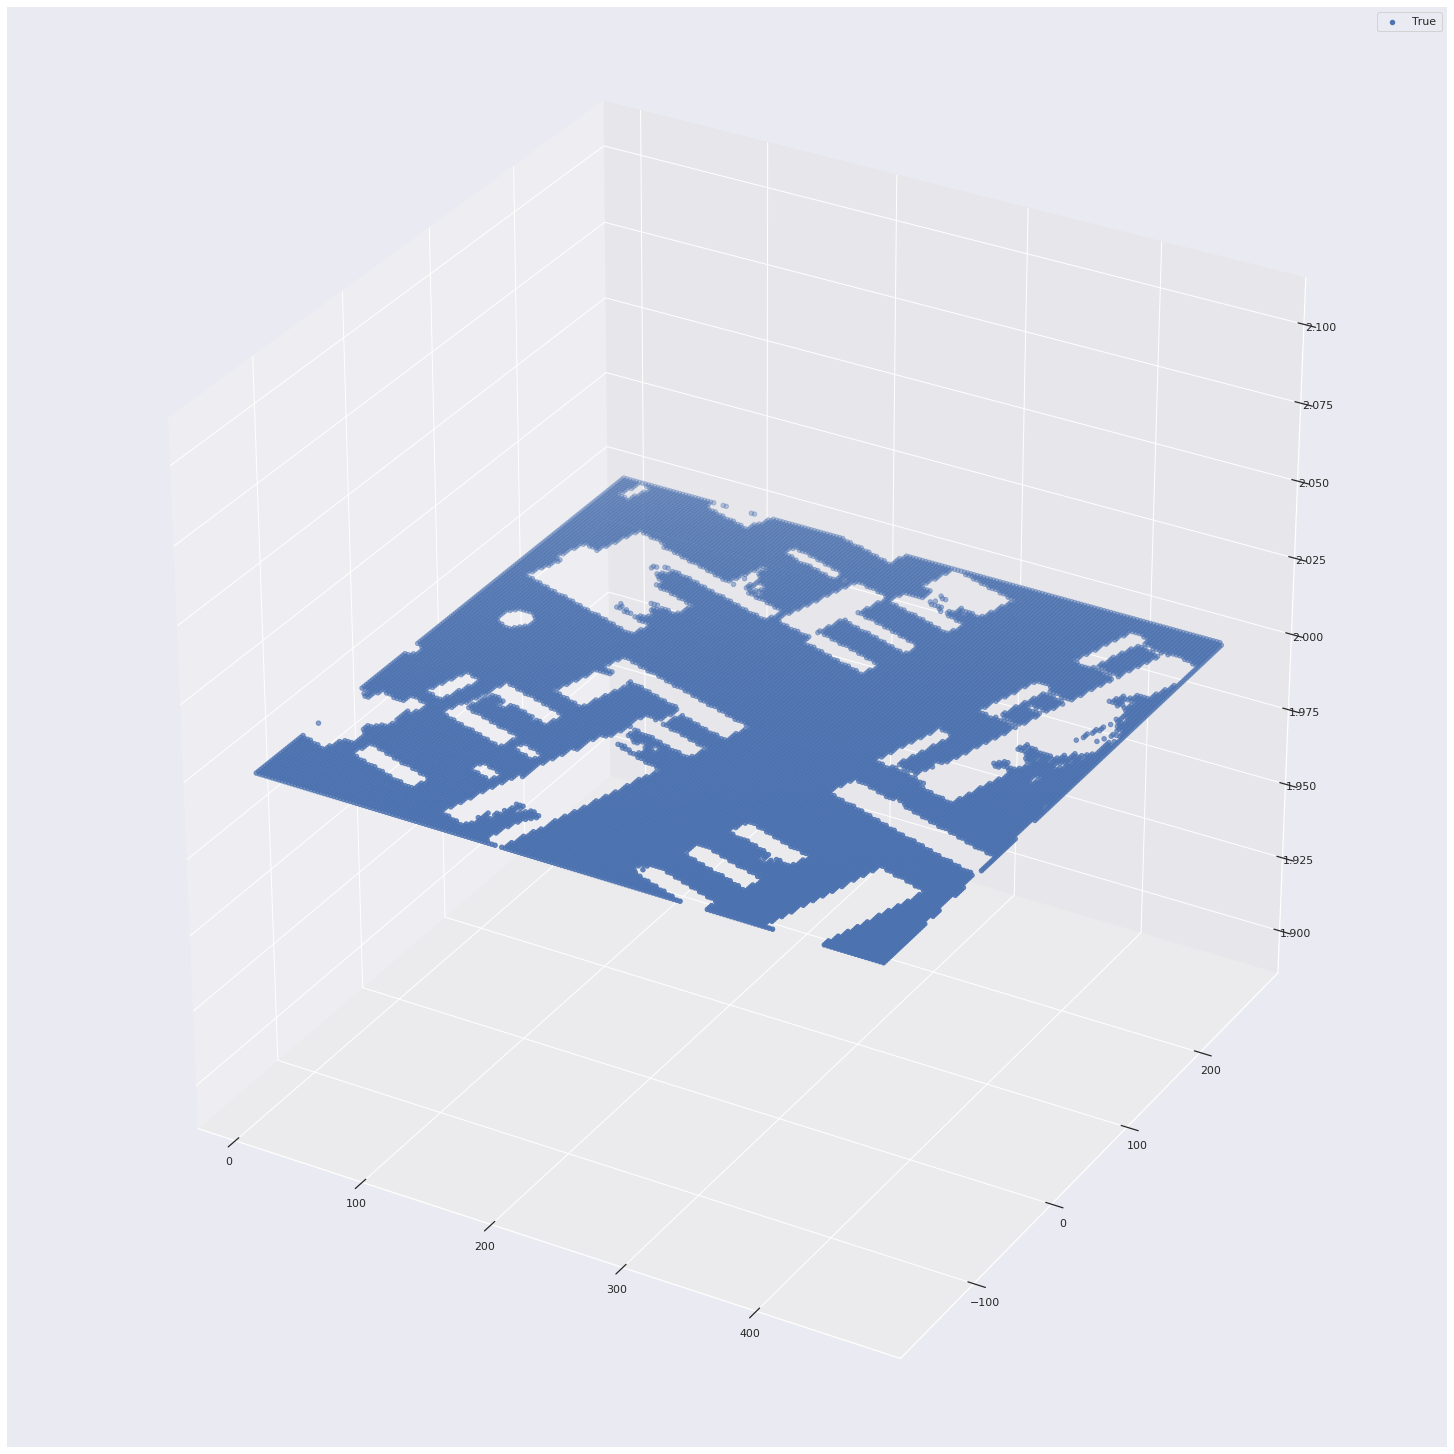

In [37]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,20))
ax = Axes3D(fig)
ax.scatter(rx_positions[:,0], rx_positions[:,1], rx_positions[:,2], label='True')
ax.legend()